In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
from tqdm import tqdm

from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from feature_decomp import Monomial
from kernels import GaussianKernel, LaplaceKernel
from utils import ensure_torch, ensure_numpy

In [2]:
EXPT_NAME = "verify-hehe"
KERNEL_WIDTH = 6
N_SAMPLES = 25_000
P_MODES = 25_000
DATA_DIM = 200

def get_expt_fm(expt_num):
    if expt_num == 0:
        DATASET = "gaussian"
        KERNEL_TYPE = GaussianKernel
        title = "Gaussian Kernel\n@ Gaussian data"
    elif expt_num == 1:
        DATASET = "cifar10"
        KERNEL_TYPE = GaussianKernel
        title = "Gaussian Kernel\n@ CIFAR10"
    elif expt_num == 2:
        DATASET = "imagenet32"
        KERNEL_TYPE = LaplaceKernel
        title = "Laplace Kernel\n@ Imagenet"

    if KERNEL_TYPE == GaussianKernel:
        DATA_EIGVAL_EXP = 3.0   # d_eff = 7
        ZCA_STRENGTH = 0        # d_eff = 7 cf10
    if KERNEL_TYPE == LaplaceKernel:
        DATA_EIGVAL_EXP = 1.6   # d_eff = 27
        ZCA_STRENGTH = 5e-3     # d_eff = 40 imnet
    
    datapath = os.getenv("DATASETPATH")
    exptpath = os.getenv("EXPTPATH")
    if datapath is None:
        raise ValueError("must set $DATASETPATH environment variable")
    if exptpath is None:
        raise ValueError("must set $EXPTPATH environment variable")
    fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}"
    if DATASET == "gaussian":
        fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
    else:
        fp += f"-zca:{ZCA_STRENGTH}"
    expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

    if not os.path.exists(expt_dir):
        raise FileNotFoundError(f"{expt_dir} doesn't exist")
    expt_fm = FileManager(expt_dir)
    return expt_fm, title


In [3]:
all_plot_results = []
for i in tqdm(range(3)):
    plot_results = {}
    expt_fm, plot_title = get_expt_fm(i)
    plot_results["title"] = plot_title
    expt_result = expt_fm.load("result.pickle")
    plot_results["expt"] = expt_result

    eigvecs = ensure_torch(expt_fm.load("kernel.pickle")["eigvecs"])
    H = ensure_torch(expt_fm.load("H.npy"))
    _, P_modes = H.shape
    M = (eigvecs[:, :P_modes].T @ H)**2
    M = ensure_numpy(M)
    plot_results["M"] = M
    
    all_plot_results.append(plot_results)


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


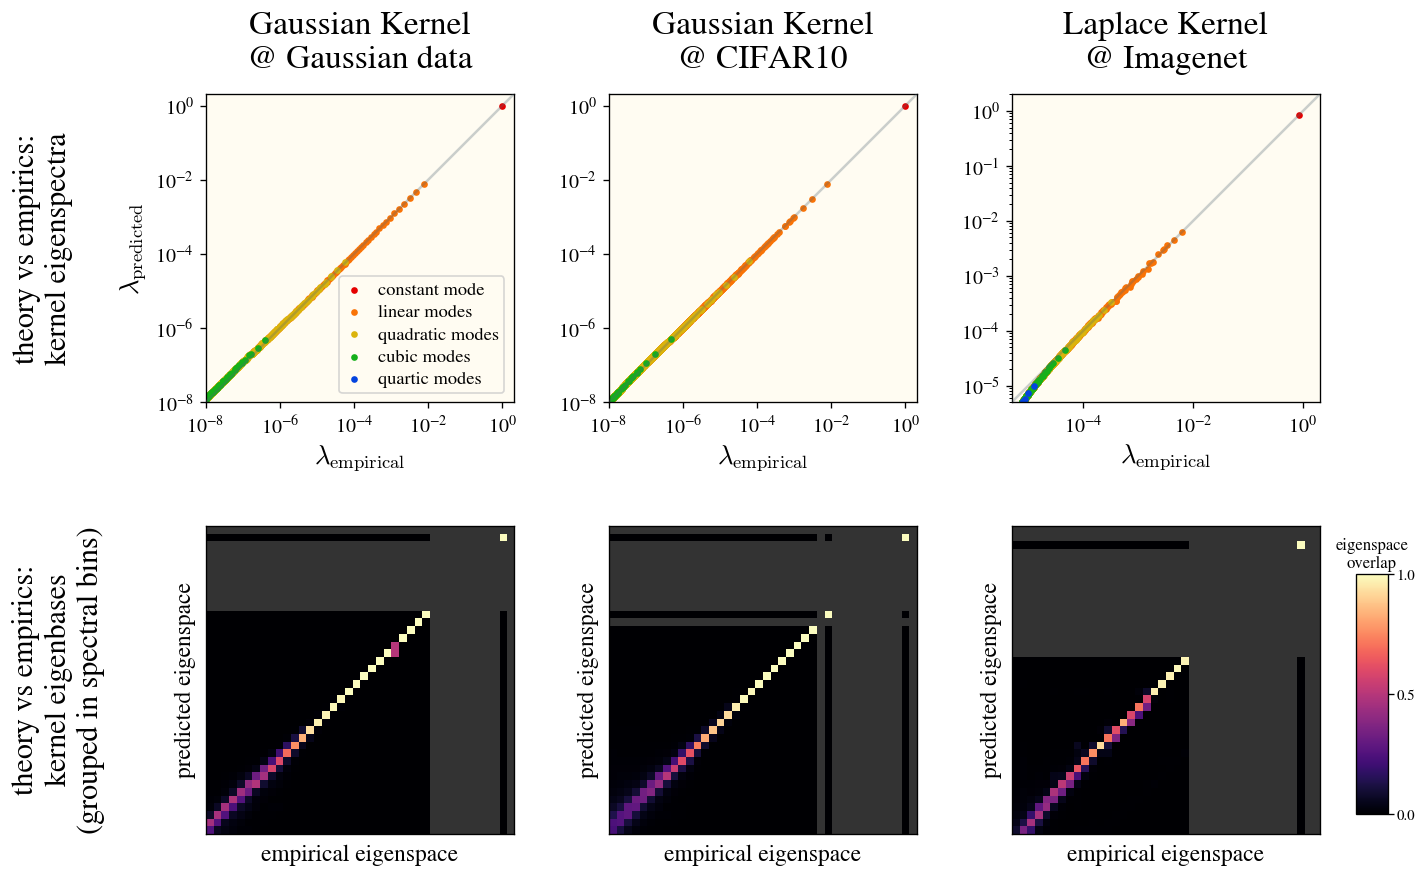

In [4]:
import matplotlib.gridspec as gridspec
import matplotlib as mpl

cmap = mpl.colormaps.get_cmap('magma')
cmap.set_bad(color="#333333")

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(2, 4, width_ratios=[0., 1, 1, 1], wspace=0.2, hspace=0.4)
axes = np.empty((2, 3), dtype=object)

titles = ["theory vs empirics:\nkernel eigenspectra\n",
          "theory vs empirics:\nkernel eigenbases\n(grouped in spectral bins)"]
for row, title in enumerate(titles):
    # Add y-title axis for each row
    ytitle_ax = fig.add_subplot(gs[row, 0])
    # Hide ticks and spines but keep ylabel visible
    ytitle_ax.set_yticks([])
    ytitle_ax.set_xticks([])
    for spine in ytitle_ax.spines.values():
        spine.set_visible(False)
    ytitle_ax.set_ylabel(title, fontsize=18, labelpad=16)
    ytitle_ax.yaxis.set_label_position('left')
    # Add main axes for each row
    for col in range(3):
        axes[row, col] = fig.add_subplot(gs[row, col+1])

for i in range(3):
    ax = axes[0, i]
    plot_results = all_plot_results[i]
    plot_title = plot_results["title"]
    ax.set_title(plot_title, fontsize=20, pad=16)
    expt_result = plot_results["expt"]

    monomials = expt_result["monomials"]
    degrees = np.array([Monomial(m).degree() for m in monomials])

    hehe_eigvals = expt_result["th_eigvals"]
    emp_eigvals = expt_result["emp_eigvals"]
    d_eff = expt_result["d_eff"]
    
    for degree in np.unique(degrees):
        if degree > 4:
            continue
        label = ["constant", "linear", "quadratic", "cubic", "quartic", "quintic"][degree]
        label += " mode" if degree==0 else " modes"
        idxs = np.where(np.array(degrees) == degree)[0]
        ax.scatter(emp_eigvals[idxs], hehe_eigvals[idxs],
                color=colors[degree%7], marker='.', label=label)

    lambda_min = 1e-8 if "Gaussian" in plot_title else 5e-6
    lambda_max = 2e0
    xx = np.linspace(lambda_min, lambda_max, 10)
    ax.set_xlim(lambda_min, lambda_max)
    ax.set_ylim(lambda_min, lambda_max)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.3, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal', 'box')

    ax.set_xlabel(f'$\\lambda_\\mathrm{{empirical}}$', fontsize=16)
    if i==0:
        ax.set_ylabel(f'$\\lambda_\\mathrm{{predicted}}$', fontsize=16)
        ax.legend(fontsize=11, loc="lower right",
                  handlelength=1.0, labelspacing=0.3, borderpad=0.3) 

    ax = axes[1, i]
    M = plot_results["M"]

    nbins = 40
    bin_edges = np.geomspace(lambda_min, lambda_max, num=(nbins+1))
    hehe_bins = np.digitize(hehe_eigvals, bin_edges) - 1
    emp_bins = np.digitize(emp_eigvals[:P_modes], bin_edges) - 1
    M_coarse = np.zeros((nbins, nbins))
    for mi in range(nbins):
        row_inds = np.where(hehe_bins == mi)[0]
        for mj in range(nbins):
            col_inds = np.where(emp_bins == mj)[0]
            if len(row_inds) == 0 or len(col_inds) == 0:
                M_coarse[mi, mj] = np.nan
                continue
            block = M[np.ix_(row_inds, col_inds)]
            M_coarse[mi, mj] = block.sum() / len(col_inds)
    
    cbar = ax.matshow(M_coarse, aspect='equal', cmap=cmap, interpolation='none',
                      origin='lower', vmax=1, vmin=0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False)
    ax.set_xlabel("empirical eigenspace", labelpad=6, fontsize=14)
    ax.set_ylabel("predicted eigenspace", labelpad=6, fontsize=14)
    

cax = fig.add_axes([0.91, 0.13, 0.02, 0.25])
cb = fig.colorbar(cbar, cax=cax)
cax.set_title("eigenspace\noverlap", fontsize=10, pad=4)
cb.ax.set_yticks([0, 0.5, 1.0])
cb.ax.tick_params(labelsize=9, pad=2)

plt.show()